# Model Creation - 2

### This model will look at local changes in rating, using vintage data to justify these changes

## Import Packages

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import pytz
import pandas as pd
import matplotlib.pyplot as plt

from numpy.polynomial.polynomial import Polynomial
from scipy.interpolate import interp1d
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

## Import Data
Start by importing the training and testing data.

In [ ]:
train = pd.read_csv(r'C:\Users\fwhal\Downloads\CME528\Project\Repo-2\BreakinBadCode\Final_DataFrames\FINAL_training_data_Model2_FINAL.csv')
train.head()

,Producer,WineType,District,Year,Ratings Average,Price,Type,January Max Temp (°C),January Min Temp (°C),January Avg Temp (°C),...,December Avg Relative Humidity,December Cumulative Rain (mm),December Cumulative Snow (mm),December Cumulative Precip (mm),December Avg Cloud Cover (%),December Max Wind Speed (Km/h),December Min Wind Speed (Km/h),December Avg Wind Speed (Km/h),December Avg Daylight Hours,Producer/WineType/Year
0,francis ford coppola winery,archimedes,Sonoma,2019,4.4,104.79,top_listed,21.273500,-0.4765,10.004548,...,98.354058,247.800000,0.0,247.800000,71.985215,25.562534,0.00,7.202130,9.533504,fisher vineyards/cabernet sauvignon/2019
1,francis ford coppola winery,archimedes,Sonoma,2018,4.4,104.79,best_user_rated,21.373500,1.2735,10.361067,...,96.505723,75.900000,0.0,75.900000,60.690860,25.346148,0.36,6.735369,9.532272,fisher vineyards/cabernet sauvignon/2018
2,francis ford coppola winery,archimedes,Sonoma,2017,4.4,104.79,NaN,19.073502,-2.3265,7.673298,...,91.867615,0.700000,0.0,0.700000,51.584677,18.356470,0.00,5.660764,9.531398,fisher vineyards/cabernet sauvignon/2017
3,francis ford coppola winery,archimedes,Sonoma,2016,4.4,104.79,NaN,17.079498,-1.9705,9.425199,...,94.394641,118.899999,0.0,118.899999,54.302419,19.645580,0.00,6.646974,9.530239,fisher vineyards/cabernet sauvignon/2016
4,francis ford coppola winery,archimedes,Sonoma,2015,4.4,104.79,NaN,23.679500,-0.6205,10.136422,...,94.876585,145.100001,0.0,145.100001,62.354838,26.302181,0.36,7.692760,9.533807,fisher vineyards/cabernet sauvignon/2015


## Exploratory Data Anlysis
Visially and graphically look at data

Looking at the districts below, we can see clear time dependent trends in the data 
- Data looks almost random. Will use weather data to explain trends

In [17]:
train['District'].unique()

array(['Sonoma', 'Napa', 'Mendocino', 'Tulare', 'San Luis Obispo',
       'Provincia de Elqui', 'San Rafael', 'Thompson--Okanagan',
       'Vancouver Island and Coast / *', 'Nechako', 'Tunuyán',
       'San Carlos', 'Luján de Cuyo', 'Tupungato', 'Barossa',
       'Unincorporated SA', 'Wattle Range', 'Toscana', 'Umbria', 'Marche',
       'Lazio', 'Gironde', 'Dordogne', 'Creuse', 'Deux-Sèvres',
       'Charente', 'Rioja, La', 'Onkaparinga',
       'Clare and Gilbert Valleys', 'Torre de Moncorvo'], dtype=object)

No visible trend initially across the years for rating average
- No change in older vintages with ratings

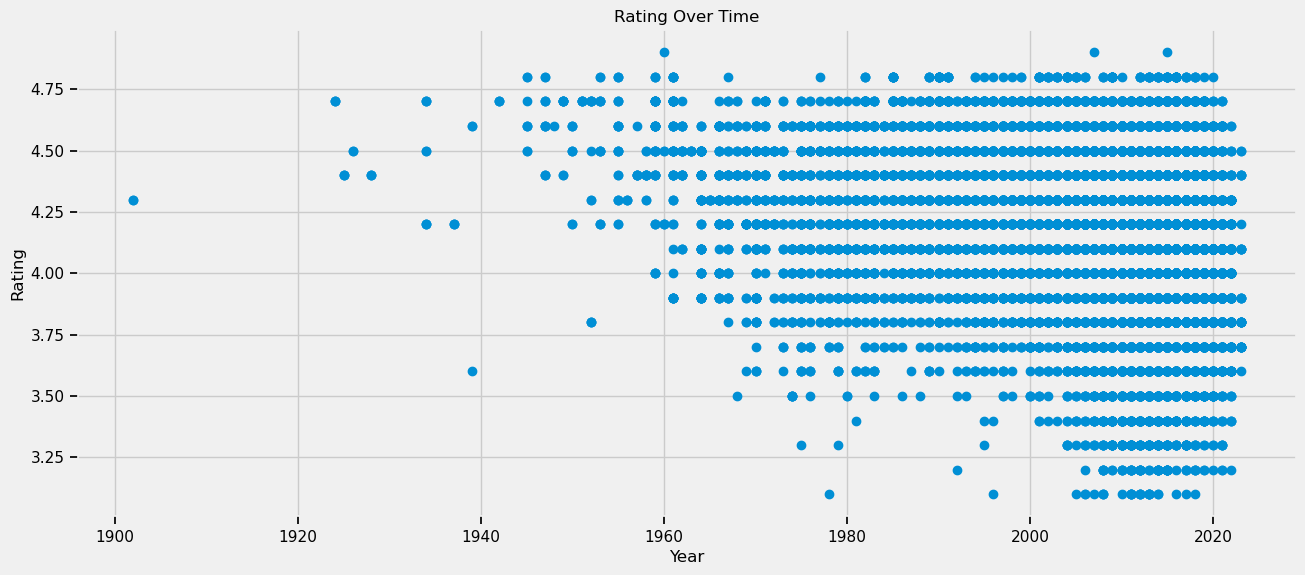

In [18]:
#Set out figure size
plt.figure(figsize=(14, 6))

#Set out lineplot and data
plt.scatter(x = train['Year'], y = train['Ratings Average'])

#Adding labels and title
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Rating Over Time')

#Show the plot
plt.show()

Looking at a heatmap, we can see a slight increasing trend of ratings with years

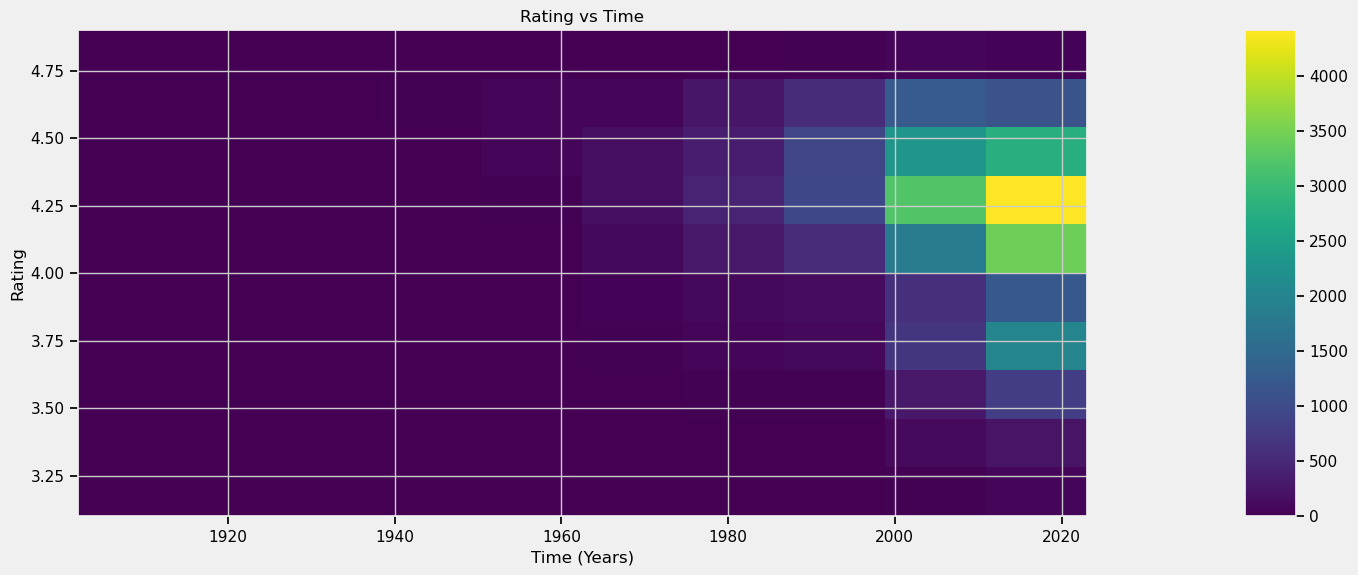

In [19]:
#Define figure size
fig = plt.figure(figsize = (14, 6)) 
gs = fig.add_gridspec(1, 2, width_ratios = [20, 1], wspace=0.3)

#Create heatmap
heatmap, xedges, yedges = np.histogram2d(train['Year'], train['Ratings Average'], bins=(10, 10))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#Add Heatmap
ax0 = fig.add_subplot(gs[0, 0])
img = ax0.imshow(heatmap.T, extent = extent, origin = 'lower', cmap = 'viridis', aspect = 'auto')
ax0.set_title('Rating vs Time')
ax0.set_xlabel('Time (Years)')
ax0.set_ylabel('Rating')

#Add colour bar
ax1 = fig.add_subplot(gs[0, 1])
cbar = fig.colorbar(img, cax=ax1)

#Plot
plt.show()


Looking at a few districts, can see a small dependency of time with rating
- Initially looking at years as a clear distinction can be seen

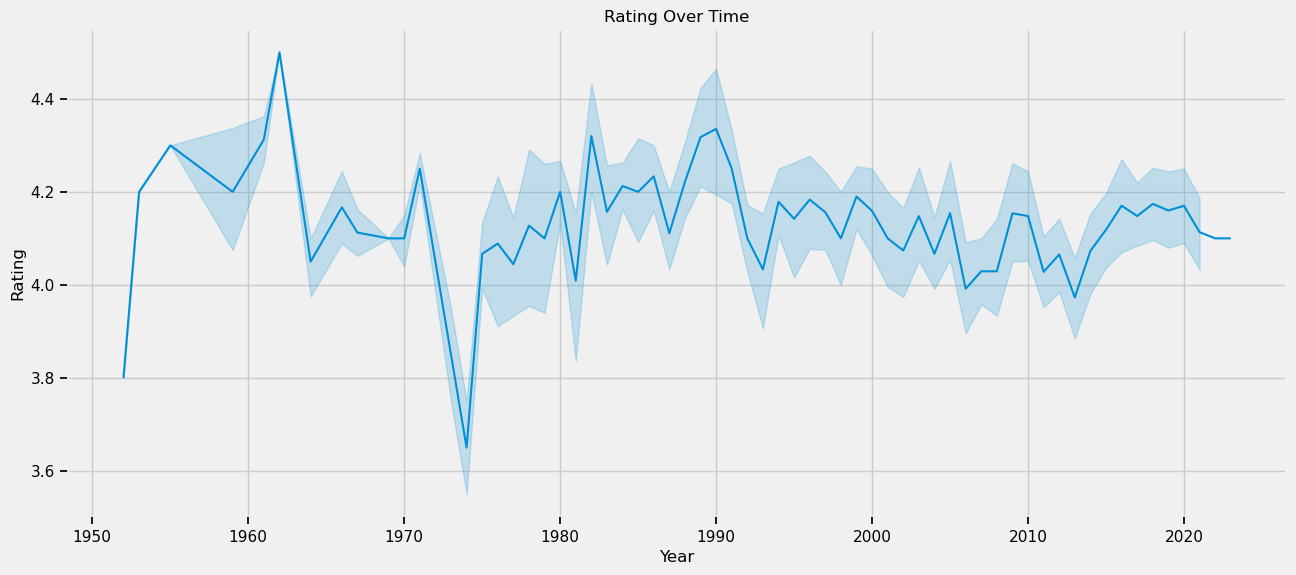

In [20]:
#Set out figure size
plt.figure(figsize=(14, 6))

#Set out lineplot and data
sns.lineplot(data = train[train['District'] == 'Dordogne'], x = 'Year', y = 'Ratings Average')

#Adding labels and title
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Rating Over Time')

#Show the plot
plt.show()

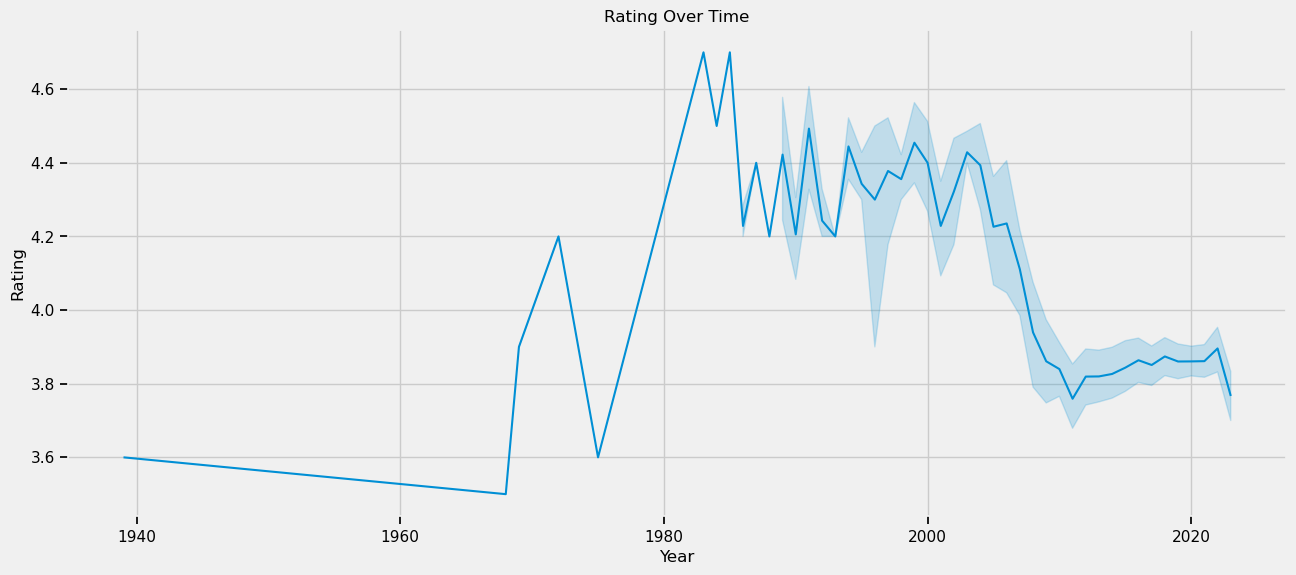

In [21]:
#Set out figure size
plt.figure(figsize=(14, 6))

#Set out lineplot and data
sns.lineplot(data = train[train['District'] == 'Tulare'], x = 'Year', y = 'Ratings Average')

#Adding labels and title
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Rating Over Time')

#Show the plot
plt.show()

Can see a decreaing trend across the years for this district
- Some bottles will show a time dependent aspect, as older vintages typically will have better ratings

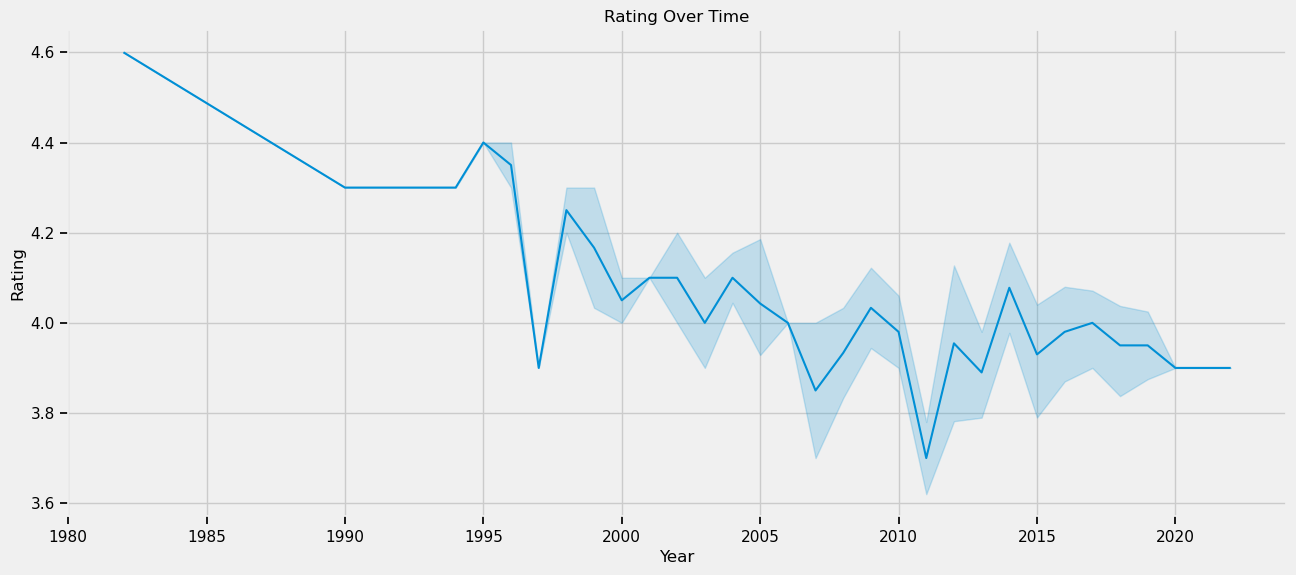

In [22]:
#Set out figure size
plt.figure(figsize=(14, 6))
sns.lineplot(data = train[train['District'] == 'Wattle Range'], x = 'Year', y = 'Ratings Average')

#Adding labels and title
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Rating Over Time')

#Show the plot
plt.show()

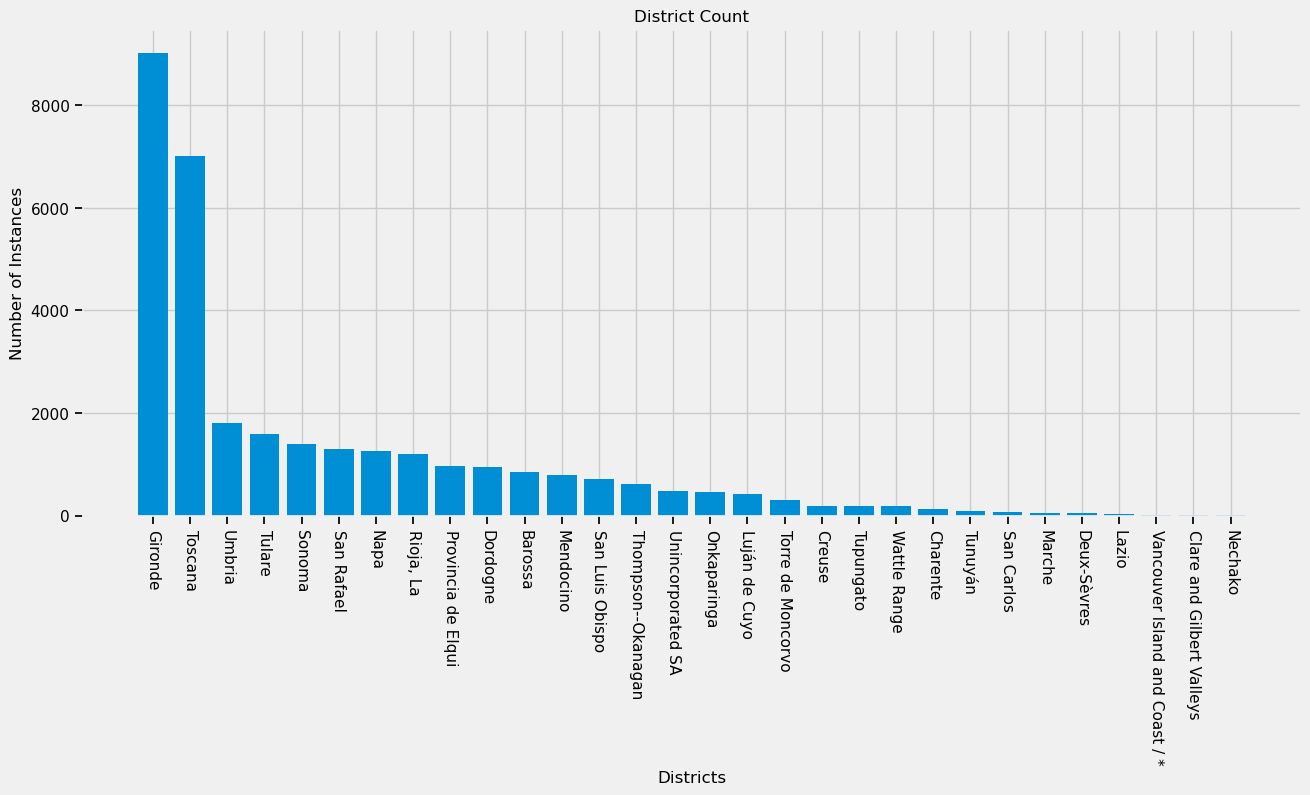

In [23]:
#Set out figure size
plt.figure(figsize=(14, 6))

#Define the data
categories =  train['District'].value_counts()

#Customizing Bar Plot
plt.bar(categories.index, categories.values)

#Adding labels and title
plt.xlabel('Districts')
plt.ylabel('Number of Instances')
plt.title('District Count')

#Rotate data
plt.xticks(rotation=270)

#Show the plot
plt.show()

## Data Cleaning Engineering
Following the input of the data, extensive measurements must be taken to clean and format the data. 

The cleaning process involves: 
- Drops duplicate rows
- Fill NaN values 



In [24]:
def Cleaning_Data(DataFrame_Clean):
    """
    Input: initial DataFrame data

    Cleans a DataFrame_ through four processes:
        1. Drops duplicate rows
        2. fills NaN values 

    Output: Cleaned DataFrame
    """

    #Drops any rows with the name producer/year
    DataFrame_Clean['Producer_Year'] = DataFrame_Clean['Producer'] + DataFrame_Clean['Year'].astype(str)
    DataFrame_Clean = DataFrame_Clean.drop_duplicates(subset = 'Producer_Year')

    #Fills NaN values with the data infront of it. Since hourly data wont have large variation between hours, this approach is valid
    DataFrame_Clean = DataFrame_Clean.fillna(0)

    return DataFrame_Clean

# Feature Engineering

This chunk of code sets out all the features that were considered for the design of a model


In [25]:
def Features(DataFrame):
    """
    Adds all features to the dataframe
    """
    months = ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 'February']
    seasons = {'Spring' : ['March', 'April', 'May'], 'Summer' : ['June', 'July', 'August'], 'Fall' : ['September', 'October', 'November'], 'Winter' : ['December', 'January', 'February']}

    for month in months: 

        #Add feature for tempxhumidity interaction 
        DataFrame[f'{month}_Temp_Humidity'] = DataFrame[f'{month} Avg Temp (°C)'] * DataFrame[f'{month} Avg Relative Humidity']

    for season in seasons:
    
        #Add feature for seasonal average temperature
        DataFrame[f'{season}_Avg_Temp'] = DataFrame[[f'{month} Avg Temp (°C)' for month in seasons[season]]].mean(axis=1)

        #Add feature for humidity average temperature
        DataFrame[f'{season}_Avg_Humid'] = DataFrame[[f'{month} Avg Relative Humidity' for month in seasons[season]]].mean(axis=1)

        #Add feature for seasonal average precip
        DataFrame[f'{season}_Avg_Precip'] = DataFrame[[f'{month} Cumulative Precip (mm)' for month in seasons[season]]].mean(axis=1)
        
        #Add feature for seasonal average cloud cover
        DataFrame[f'{season}_Avg_Cloud_Cover'] = DataFrame[[f'{month} Avg Cloud Cover (%)' for month in seasons[season]]].mean(axis=1)

        #Add feature for seasonal daylight hours
        DataFrame[f'{season}_Avg_Daylight_Hrs'] = DataFrame[[f'{month} Avg Daylight Hours' for month in seasons[season]]].mean(axis=1)
    
        #Add feature for seasonal temp humidity
        DataFrame[f'{season}_Temp_Humidity'] = DataFrame[[f'{month}_Temp_Humidity' for month in seasons[season]]].mean(axis=1)

        #Add feature for days below 0 per month
        DataFrame[f'{season}_Days_Below_0'] = DataFrame[[f'{month} Days Below 0 (°C)' for month in seasons[season]]].sum(axis = 1)
    
        #Add feature for days above 32 per month
        DataFrame[f'{season}_Days_Above_32'] = DataFrame[[f'{month} Days Above 32 (°C)' for month in seasons[season]]].sum(axis = 1)
    return DataFrame

## Selecting Features 

The feature selection function takes in all the added features, removing many of the ones that were determined to not help the data well. 
- Removed features were done based on the utility graph later on

In [26]:
def Feature_Selection(data):
    """
    Input: Raw data, with every feature from the cleaned train data set
        Commenting them in and out, certain features are chosen for the final model 
    Output: Final dataset, with certain features chosen 
    """
    feature_selected = [
                        # 'Year', ##

                        # 'Winter_Avg_Temp', 

                        'Spring_Avg_Temp',

                        'Summer_Avg_Temp',
                        # 'June Avg Temp (°C)', ##
                        # 'July Avg Temp (°C)', ##
                        # 'August Avg Temp (°C)', ##                                     

                        # 'Fall_Avg_Temp', ##

                        # 'Winter_Avg_Humid', ## 

                        'Spring_Avg_Humid',

                        # 'Summer_Avg_Humid', ##

                        # 'Fall_Avg_Humid', ##

                        'Winter_Avg_Precip', 

                        # 'Spring_Avg_Precip',

                        # 'Summer_Avg_Precip', ##

                        # 'Fall_Avg_Precip', ##

                        # 'Winter_Avg_Cloud_Cover', ##
                        # 'January Avg Cloud Cover (%)',
                        # 'February Avg Cloud Cover (%)',

                        # 'Spring_Avg_Cloud_Cover',
                        # 'March Avg Cloud Cover (%)',
                        # 'April Avg Cloud Cover (%)', ##
                        # 'May Avg Cloud Cover (%)', ##

                        'Summer_Avg_Cloud_Cover',

                        # 'Fall_Avg_Cloud_Cover', ##

                        'Winter_Avg_Daylight_Hrs',

                        'Spring_Avg_Daylight_Hrs',

                        'Summer_Avg_Daylight_Hrs',

                        # 'Fall_Avg_Daylight_Hrs', ##

                        # 'Winter_Temp_Humidity',

                        'Spring_Temp_Humidity',

                        'Summer_Temp_Humidity',

                        'Fall_Temp_Humidity',

                        # 'Winter_Days_Below_0',
                        # 'December Days Below 0 (°C)',
                        # 'January Days Below 0 (°C)',
                        # 'February Days Below 0 (°C)',        

                        # 'Spring_Days_Below_0',

                        # 'Summer_Days_Below_0',

                        # 'Fall_Days_Below_0',

                        # 'Winter_Days_Above_32',

                        # 'Spring_Days_Above_32',

                        # 'Summer_Days_Above_32',

                        # 'Fall_Days_Above_32'

                        
                        ]

    selected_data = data[feature_selected]
    selected_data = selected_data.astype(np.float32)

    return selected_data

## Selecting and Splitting Data

Look at the different y_data we can group by to help with final prediction

In [27]:
training_data_y = pd.DataFrame()
training_data_y['Ratings Average'] = train['Ratings Average']

quality_wines = {
    3.6 : 'Very Bad',
    3.7 : 'Very Bad',
    3.8 : 'Very Bad',
    3.9 : 'Very Bad',
    4.0 : 'Bad',
    4.1 : 'Bad',
    4.2 : 'Bad',
    4.3 : 'Okay',
    4.4 : 'Okay',
    4.5 : 'Okay',
    4.4 : 'Good',
    4.5 : 'Good',
    4.6 : 'Good',
    4.7 : 'Very Good',
    4.8 : 'Very Good',
    4.9 : 'Very Good' 
}

quality_wines_code = {
    'Very Bad' : 1,
    'Bad' : 2,
    'Okay' : 3,
    'Good' : 4,
    'Very Good' : 5,
}

training_data_y['Classification'] = training_data_y['Ratings Average'].map(quality_wines)
training_data_y['Classification_Codes'] = training_data_y['Classification'].map(quality_wines_code)

training_data_y.head()

,Ratings Average,Classification,Classification_Codes
0,4.4,Good,4.0
1,4.4,Good,4.0
2,4.4,Good,4.0
3,4.4,Good,4.0
4,4.4,Good,4.0


In [28]:
train = Cleaning_Data(train)
train = Features(train)

X_data = Feature_Selection(train)
y_data = training_data_y['Ratings Average']

model = RandomForestRegressor() 

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, train_size = 0.8, random_state = 42)


KeyError: "None of [Index(['March Days Below 0 (°C)', 'April Days Below 0 (°C)',\n       'May Days Below 0 (°C)'],\n      dtype='object')] are in the [columns]"

## Training and Evaluating a Model

Simple model initially to iterate quickly to check r2 scores

Following this, hyperparameters were determined for the final submissions

In [ ]:
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print(r2_score(y_val, y_pred))

0.6499831278390664


## Evaluating features

Iterated through this evaluation code to determine best combination of the many features and how many should be included
- This was done on a simple model, with hyperparameter tuning done in the final step submissions


Top 15 Important Features:
                    Feature  Importance
2          Spring_Avg_Humid    0.164014
5   Winter_Avg_Daylight_Hrs    0.118890
6   Spring_Avg_Daylight_Hrs    0.105018
8      Spring_Temp_Humidity    0.103607
10       Fall_Temp_Humidity    0.097395
7   Summer_Avg_Daylight_Hrs    0.091026
9      Summer_Temp_Humidity    0.079767
4    Summer_Avg_Cloud_Cover    0.079268
1           Summer_Avg_Temp    0.058294
3         Winter_Avg_Precip    0.051677
0           Spring_Avg_Temp    0.051044


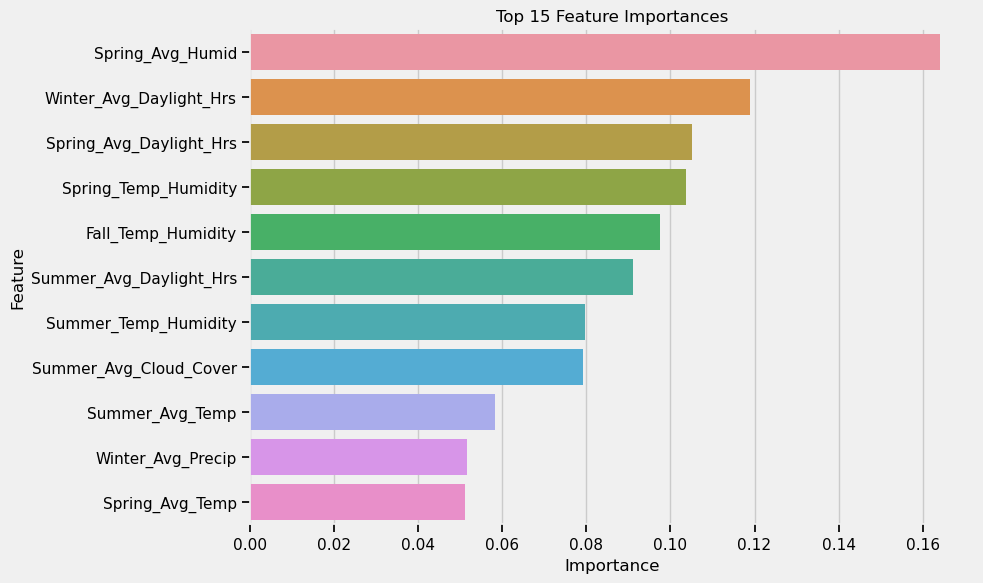

In [ ]:
# Feature importances
importances = model.feature_importances_
feature_names = X_data.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
print("\nTop 15 Important Features:")
print(feature_importance_df.head(15))

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

## Identifying Trends

Looking at the popular features, we can now graph the applicable features and the rating average 

Spring_Avg_Humid
- Can see a slight negative trend, with a large volume of data at 92.5% and 4.4 rating roughly

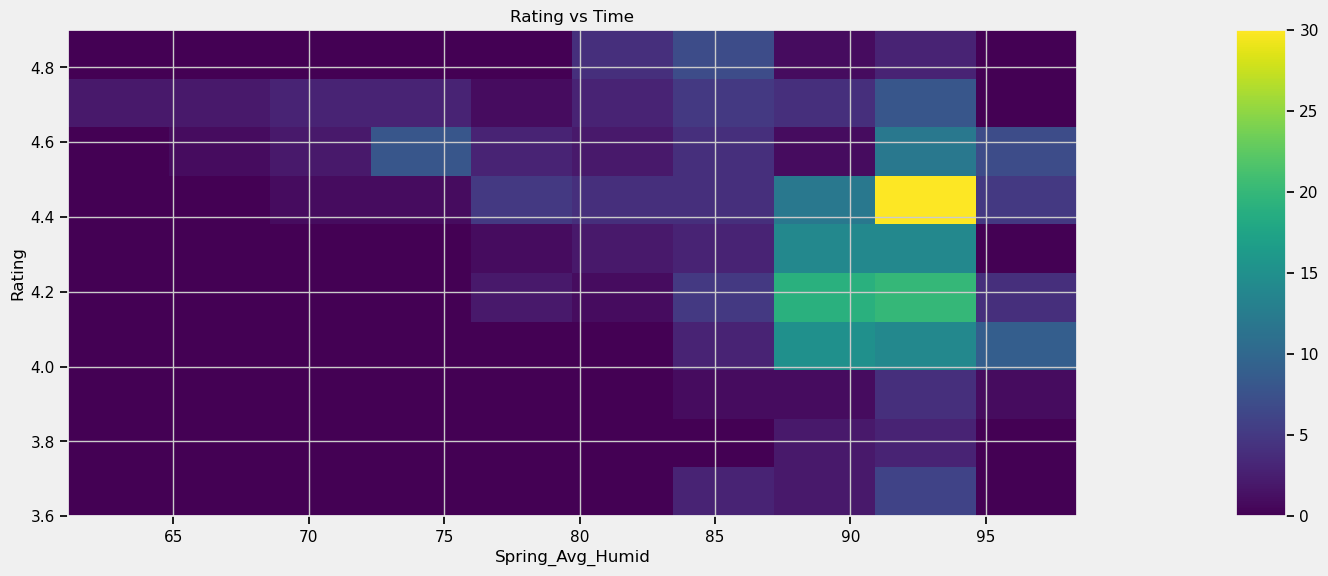

In [ ]:
#Define figure size
fig = plt.figure(figsize = (14, 6)) 
gs = fig.add_gridspec(1, 2, width_ratios = [20, 1], wspace=0.3)

#Create heatmap
heatmap, xedges, yedges = np.histogram2d(train['Spring_Avg_Humid'], train['Ratings Average'], bins=(10, 10))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#Add Heatmap
ax0 = fig.add_subplot(gs[0, 0])
img = ax0.imshow(heatmap.T, extent = extent, origin = 'lower', cmap = 'viridis', aspect = 'auto')
ax0.set_title('Rating vs Time')
ax0.set_xlabel('Spring_Avg_Humid')
ax0.set_ylabel('Rating')

#Add colour bar
ax1 = fig.add_subplot(gs[0, 1])
cbar = fig.colorbar(img, cax=ax1)

#Plot
plt.show()

In [ ]:
for i in train.columns:
    print(i)

Producer
District
Year
Ratings Average
WineType_x
January Max Temp (°C)
January Min Temp (°C)
January Avg Temp (°C)
January Max Relative Humidity
January Min Relative Humidity
January Avg Relative Humidity
January Cumulative Rain (mm)
January Cumulative Snow (mm)
January Cumulative Precip (mm)
January Avg Cloud Cover (%)
January Max Wind Speed (Km/h)
January Min Wind Speed (Km/h)
January Avg Wind Speed (Km/h)
January Avg Daylight Hours
January Days Below 0 (°C)
January Days Above 32 (°C)
February Max Temp (°C)
February Min Temp (°C)
February Avg Temp (°C)
February Max Relative Humidity
February Min Relative Humidity
February Avg Relative Humidity
February Cumulative Rain (mm)
February Cumulative Snow (mm)
February Cumulative Precip (mm)
February Avg Cloud Cover (%)
February Max Wind Speed (Km/h)
February Min Wind Speed (Km/h)
February Avg Wind Speed (Km/h)
February Avg Daylight Hours
February Days Below 0 (°C)
February Days Above 32 (°C)
March Max Temp (°C)
March Min Temp (°C)
March Av